In [1]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import numpy as np
from yolov8_cam.activations_and_gradients import ActivationsAndGradients
from fem_xai import compute_fem

# Use the default COCO pretrained model for the following demo
model = YOLO("best.pt")

img = cv2.imread('images\Frame_4000.png')
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255




In [2]:
import torch.nn as nn
# Access the last layer and remove its activation function
model.model.model[0].activation = nn.Identity()


In [3]:

target_layers = [model.model.model[-3]]


0: 640x640 (no detections), 15.3ms
Speed: 14.2ms preprocess, 15.3ms inference, 1643.9ms postprocess per image at shape (1, 3, 640, 640)
Shape of the activations: (1, 320, 320, 16)


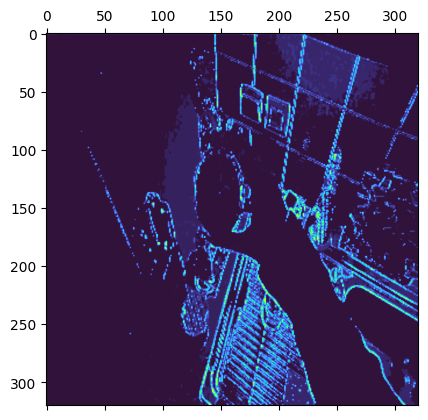

In [4]:
activations_and_grads = ActivationsAndGradients(model, target_layers,None)
outputs = activations_and_grads(img)
activations_out = activations_and_grads.activations
#print(f"shape of the activations : {activations_out.shape}")

feature_map_reshaped = activations_out[-1].permute(0, 2, 3, 1)
feature_map_numpy = feature_map_reshaped.numpy()
print(f"Shape of the activations: {feature_map_numpy.shape}")
# Generate saliency with FEM algorithm
saliency = compute_fem(feature_map_numpy)

plt.matshow(saliency, cmap="turbo", vmin=0, vmax=1, interpolation="gaussian")
plt.savefig('res.png')
plt.show()


0: 640x640 1 Mug, 89.4ms
Speed: 8.0ms preprocess, 89.4ms inference, 151.4ms postprocess per image at shape (1, 3, 640, 640)


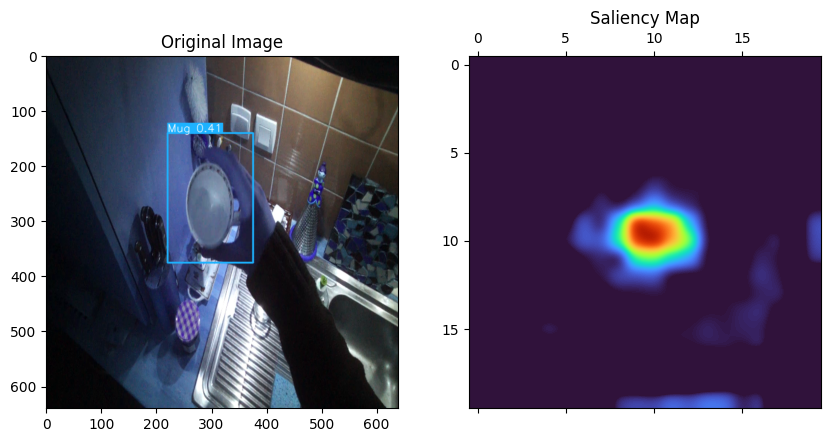

In [5]:
results = model(rgb_img )

# Visualize the results on the frame
annotated_frame = results[0].plot()

# Create a figure and axis object
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot original image
axs[0].imshow(annotated_frame)
axs[0].set_title('Original Image')

# Plot saliency map
axs[1].matshow(saliency, cmap="turbo", vmin=0, vmax=1, interpolation="gaussian")
axs[1].set_title('Saliency Map')

# Save the figure
plt.savefig('res.png')

# Show the plot
plt.show()

In [55]:
import tensorflow as tf
import matplotlib.cm as cm
from IPython.display import Image, display
def save_fem_superimposed_visualization(img_path, saliency, superimposed_img_path="superimposed_img_fem.jpg", alpha=0.6):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)
    #print(saliency)

    # Rescale saliency as a heatmap to a range 0-255
    heatmap = np.uint8(255 * saliency)

    # Use turbo colormap to colorize heatmap
    turbo = cm.get_cmap("turbo")

    # Use RGB values of the colormap
    turbo_colors = turbo(np.arange(256))[:, :3]
    turbo_heatmap = turbo_colors[heatmap]

    # Create an image with RGB colorized heatmap
    turbo_heatmap = tf.keras.preprocessing.image.array_to_img(turbo_heatmap)
    turbo_heatmap = turbo_heatmap.resize((img.shape[1], img.shape[0]))
    turbo_heatmap = tf.keras.preprocessing.image.img_to_array(turbo_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = turbo_heatmap * alpha + img * 0.2
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(superimposed_img_path)
    
    return superimposed_img_path

C:\Users\rohin\AppData\Local\Temp\ipykernel_26768\4000556773.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  turbo = cm.get_cmap("turbo")


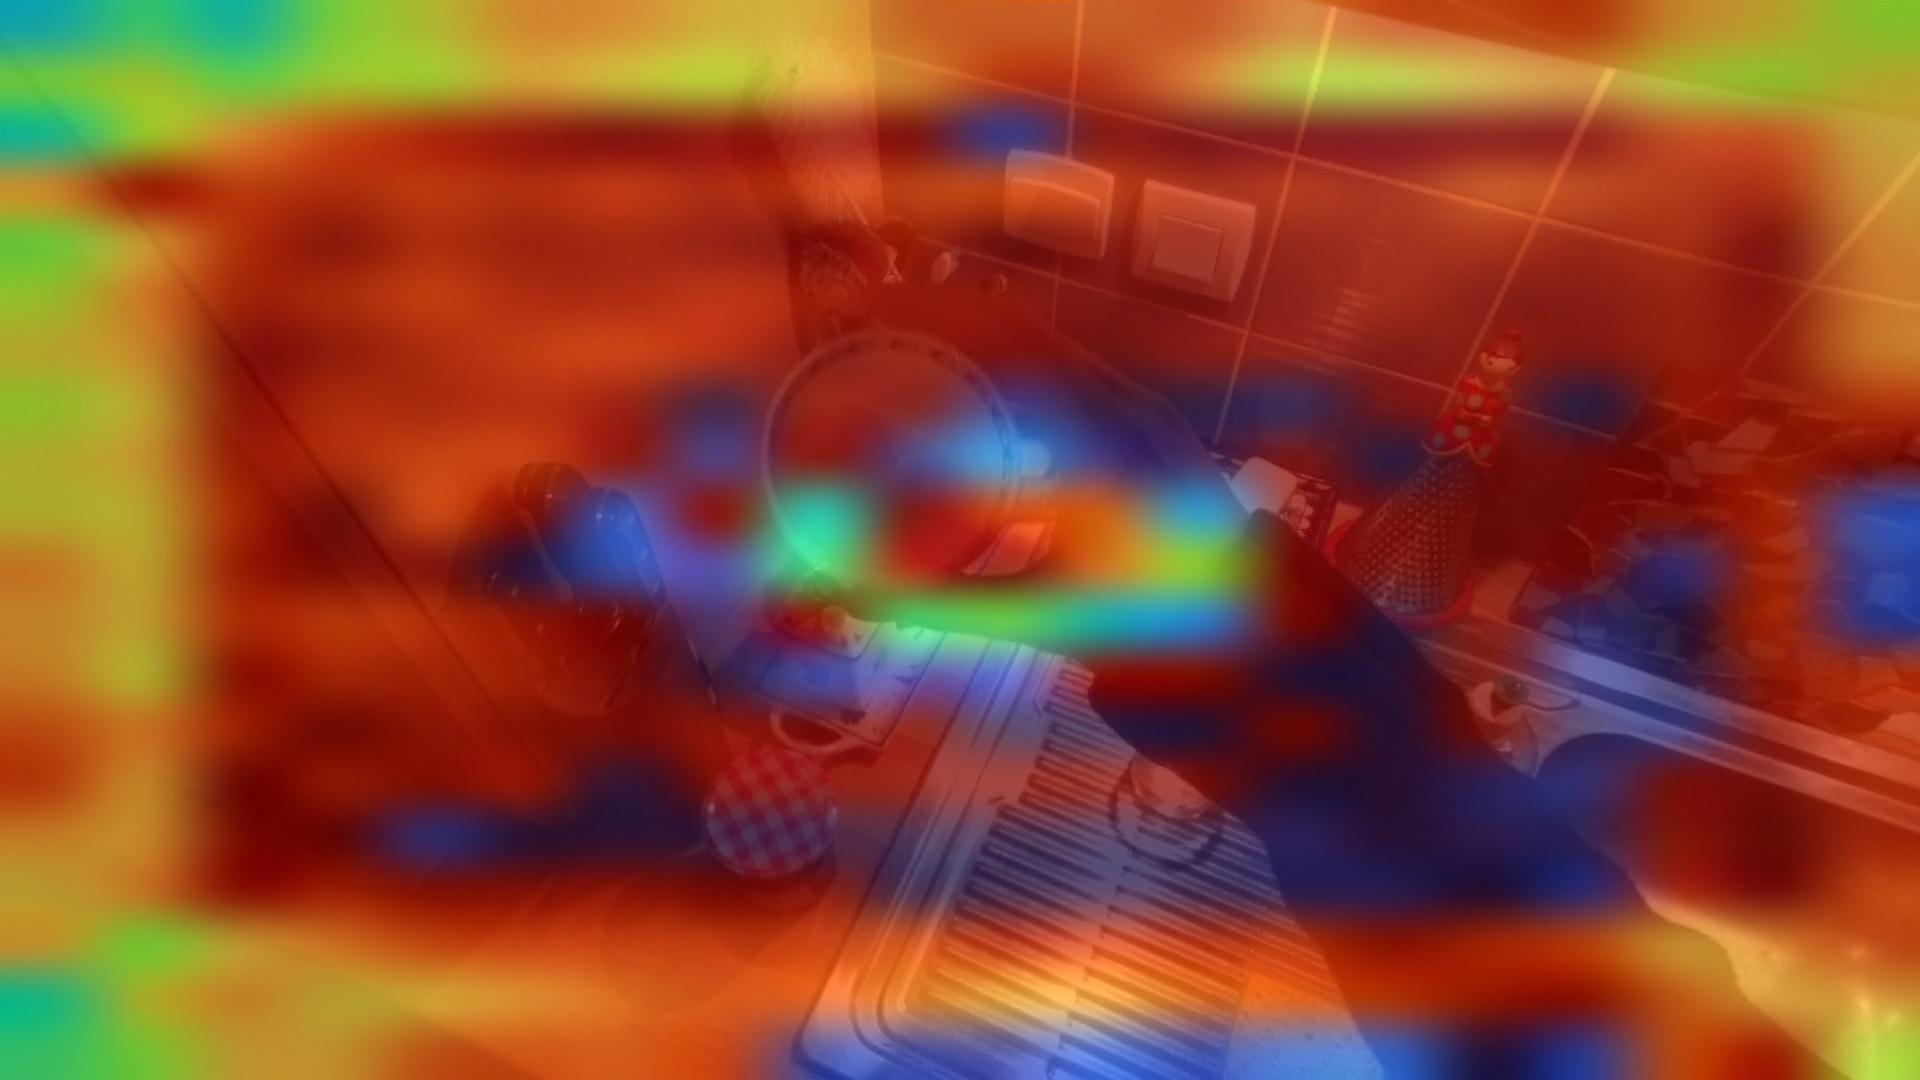

In [56]:
path = save_fem_superimposed_visualization('images\Frame_4000.png', saliency)
# Display image with a heatmap from FEM saliency
display(Image(path))